# **3. Feature Engineering**

## **3.1 Objective**
* **Goal:** Transform raw nutritional data into "Derived Features" that capture complex biological relationships (e.g., Diet Quality Ratios, Metabolic Risk Indices).
* **Consistency:** We apply the same strict cleaning rules as the EDA phase.
* **Strategy:** We will **NOT** drop missing values in this notebook. We preserve the full dataset (Country-Year granularity) so that the advanced models (Gradient Boosting) can handle imputation or sparsity later.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Data
try:
    df = pd.read_csv('../data/UnifiedDataset.csv')
    print(f"✅ Data Loaded. Original Shape: {df.shape}")
except FileNotFoundError:
    print("❌ Error: 'UnifiedDataset.csv' not found.")

✅ Data Loaded. Original Shape: (22050, 150)


## **3.2 Strict Data Cleaning (Removing All Aggregates)**
We must ensure no "Region" or "Income Group" averages remain in the dataset to prevent data leakage.

In [4]:
# The Full Exclusion List (Matching EDA)
aggregates = [
    "World", "Africa", "Americas", "Asia", "Europe", "Oceania",
    "High income countries", "Low-income countries", "Middle-income countries",
    "Upper-middle-income countries", "Lower-middle-income countries",
    "European Union", "Sub-Saharan Africa", "Latin America and the Caribbean",
    "More Developed Regions", "Less Developed Regions",
    "Central and Southern Asia", "Eastern and South-Eastern Asia",
    "Northern Africa and Western Asia", "Europe and Northern America"
]

# Filter
df = df[~df['Country'].isin(aggregates)].copy()
print(f"Rows after removing aggregates: {df.shape[0]}")

Rows after removing aggregates: 20760


## **3.3 Creating Derived Features**
We create 5 specific indices to capture the "quality" of the diet.

In [5]:
# 1. Metabolic Risk Combo (Sugar * Fat)
# Rationale: The combination of high sugar and high fat is metabolically more damaging than the sum of its parts.
df['Risk_Metabolic_Combo'] = df['Diet Composition Sugar'] * df['Diet Calories Fat']

# 2. Veg-to-Grain Ratio (Diet Quality)
# Rationale: Measures if the diet is nutrient-dense (Veg) or energy-dense (Grains).
# We add +1 to the denominator to handle cases where grain consumption might be zero/missing.
df['Ratio_Veg_to_Grain'] = df['Vegetable Consumption'] / (
    df['Cereal Consumption Wheat'] + df['Cereal Consumption Rice'] + 1
)

# 3. Protein Source Ratio (Plant / Animal)
# Rationale: Plant protein correlates with fiber; Animal protein correlates with saturated fat.
df['Ratio_Plant_to_Animal'] = df['Diet Calories Plant Protein'] / (df['Diet Calories Animal Protein'] + 1)

# 4. Wheat Dominance Index (Turkey Specific)
# Rationale: What percentage of total cereal intake is JUST Wheat?
# This is crucial for distinguishing Turkey's diet from Rice-based (Asia) or Corn-based (Americas) diets.
df['Index_Wheat_Dominance'] = df['Cereal Consumption Wheat'] / (df['Diet Composition Cereals And Grains'] + 1)

# 5. Fruit Variety Score
# Rationale: Summing specific fruit types. A higher score implies a more diverse fruit intake.
# We use .fillna(0) inside the sum so we calculate a score even if one fruit column is missing.
df['Score_Fruit_Variety'] = (
    df['Fruit Consumption Apples'].fillna(0) +
    df['Fruit Consumption Oranges And Mandarines'].fillna(0) +
    df['Fruit Consumption Lemons And Limes'].fillna(0) +
    df['Fruit Consumption Bananas'].fillna(0)
)

## **3.4 Feature Validation**
Let's check if these new features have any relationship with the target, or if they are just noise.

Correlation of New Features with Cardiovascular Death:
Ratio_Plant_to_Animal    0.258948
Ratio_Veg_to_Grain      -0.154775
Index_Wheat_Dominance   -0.164055
Score_Fruit_Variety     -0.297881
Risk_Metabolic_Combo    -0.437297
Name: % Death Cardiovascular, dtype: float64


/tmp/ipython-input-2375315087.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.drop(target).values, y=correlations.drop(target).index, palette="viridis")


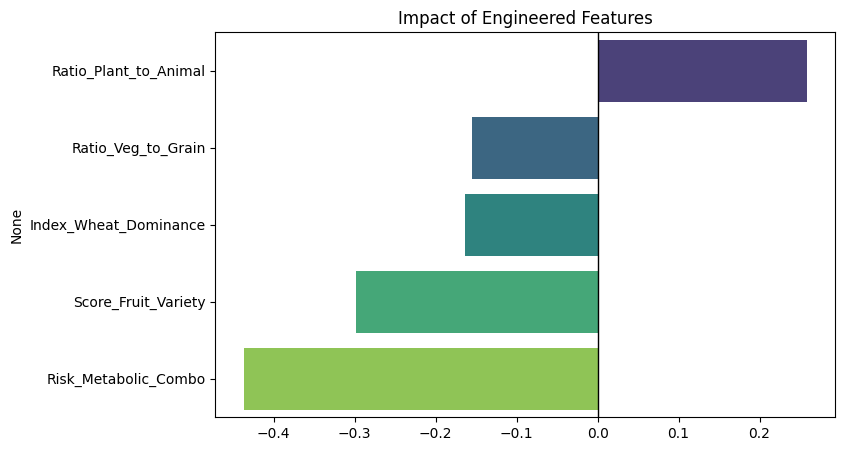

In [6]:
target = '% Death Cardiovascular'
new_features = [
    'Risk_Metabolic_Combo', 'Ratio_Veg_to_Grain', 'Ratio_Plant_to_Animal',
    'Index_Wheat_Dominance', 'Score_Fruit_Variety'
]

# Check correlations on the subset of data that isn't missing
valid_data = df[new_features + [target]].dropna()
correlations = valid_data.corr()[target].sort_values(ascending=False)

print("Correlation of New Features with Cardiovascular Death:")
print(correlations.drop(target))

# Visualize
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.drop(target).values, y=correlations.drop(target).index, palette="viridis")
plt.title("Impact of Engineered Features")
plt.axvline(0, color='black', linewidth=1)
plt.show()

## **3.5 Defining Final Feature Set & Saving**
We combine our original 25 features with the 5 new ones.

In [8]:
original_features = [
    'Gender', '% Population Aged 0-14', '% Population Aged 15-64', '% Population Aged 65+',
    'Diet Calories Fat', 'Diet Calories Carbohydrates', 'Diet Calories Animal Protein', 'Diet Calories Plant Protein',
    'Diet Composition Sugar', 'Diet Composition Oils And Fats', 'Diet Composition Meat',
    'Diet Composition Dairy And Eggs', 'Diet Composition Fruit And Vegetables',
    'Diet Composition Starchy Roots', 'Diet Composition Pulses', 'Diet Composition Cereals And Grains',
    'Diet Composition Alcoholic Beverages', 'Diet Composition Other',
    'Vegetable Consumption', 'Cereal Consumption Wheat', 'Cereal Consumption Rice',
    'Fruit Consumption Bananas', 'Fruit Consumption Oranges And Mandarines',
    'Fruit Consumption Apples', 'Fruit Consumption Lemons And Limes'
]

# Full list of columns to keep
cols_to_keep = original_features + new_features + [target, 'Country', 'Year']

# Create final dataframe
df_engineered = df[cols_to_keep].copy()

print(f"------------------------------------------------")
print(f"ENGINEERING COMPLETE")
print(f"------------------------------------------------")
print(f"Original Rows:     {df.shape[0]}")
print(f"Final Rows Saved:  {df_engineered.shape[0]} (No rows dropped)")
print(f"Total Features:    {len(original_features) + len(new_features)}")
print(f"------------------------------------------------")

# Save
df_engineered.to_csv('../data/UnifiedDataset_Engineered.csv', index=False)
print("✅ Saved to '../data/UnifiedDataset_Engineered.csv'")

------------------------------------------------
ENGINEERING COMPLETE
------------------------------------------------
Original Rows:     20760
Final Rows Saved:  20760 (No rows dropped)
Total Features:    30
------------------------------------------------
✅ Saved to '../data/UnifiedDataset_Engineered.csv'
